In [1]:
from ubibetter.models.compute_fraction  import compute_fraction
from ubibetter.utils.data.get_neigbours import get_neighbours
from ubibetter.models.compute_fraction import compute_fraction
from betbrain.manager.data_manager import data_manager

import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dm = data_manager(sport='Football')

In [3]:
data = dm.__get_data__()

In [4]:
data.head()

odds             prob               book  \
                                        A    D     H     A     D     H          
MatchDate  HomeTeam  AwayTeam   bkmr                                            
2000-07-28 Marseille Troyes     GB    4.3  3.3  1.65  0.20  0.27  0.53  0.142   
                                IW    5.0  3.5  1.45  0.17  0.24  0.59  0.175   
                                SB    5.5  3.5  1.53  0.16  0.25  0.58  0.121   
                                WH    6.0  3.5  1.45  0.15  0.25  0.60  0.142   
           Paris SG  Strasbourg GB    4.6  3.4  1.60  0.19  0.26  0.55  0.137   

                                     FTR  
                                          
MatchDate  HomeTeam  AwayTeam   bkmr      
2000-07-28 Marseille Troyes     GB     H  
                                IW     H  
                                SB     H  
                                WH     H  
           Paris SG  Strasbourg GB     H

In [5]:
train = data[data.index.get_level_values(0) < datetime(2019, 10, 1)]
test  = data[data.index.get_level_values(0) > datetime(2019, 10, 1)]

In [6]:
test.head()

odds              prob              \
                                         A     D     H     A     D     H   
MatchDate  HomeTeam  AwayTeam   bkmr                                       
2019-10-04 Charleroi Anderlecht B365  2.87  3.30  2.37  0.32  0.28  0.39   
                                BW    2.90  3.40  2.50  0.33  0.28  0.39   
                                IW    2.75  3.35  2.40  0.34  0.28  0.39   
                                PS    2.85  3.63  2.45  0.34  0.27  0.39   
                                VC    2.80  3.40  2.45  0.34  0.28  0.39   

                                       book FTR  
                                                 
MatchDate  HomeTeam  AwayTeam   bkmr             
2019-10-04 Charleroi Anderlecht B365  0.073   A  
                                BW    0.039   A  
                                IW    0.079   A  
                                PS    0.035   A  
                                VC    0.059   A

In [7]:
matrix = dm.ubibetter.get_matrix(train,[('prob', 'A'), ('prob', 'H'), 'FTR'])

/Users/Gabriele/Library/Mobile Documents/com~apple~CloudDocs/Kellify/Projects/ubipy/env/lib/python3.7/site-packages/pandas/core/generic.py:3947: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [8]:
matrix.head()

FTR                         A    D    H
(prob, A) (prob, H)                    
0.01      0.92       0.0  0.0  0.0  2.0
          0.93       0.0  0.0  0.0  4.0
          0.94       0.0  0.0  0.0  2.0
0.02      0.87       0.0  0.0  0.0  2.0
          0.88       0.0  1.0  0.0  5.0

In [9]:
vicini = test.prob[['A', 'H']].apply(get_neighbours, axis=1).rename('NN').to_frame()
probs  = vicini.apply(dm.ubibetter.__compute_probs_avg__, axis=1, args=[matrix])
probs.columns = pd.MultiIndex.from_tuples([('KLFY', c) for c in probs.columns])

In [10]:
aux = pd.concat([test.odds.stack().rename('odd'), probs.KLFY.stack().rename('prob')], axis=1, join='inner')
aux = aux.reset_index(level=4).merge(test['FTR'], right_index=True, left_index=True)
aux = aux.set_index('level_4', append=True)

In [11]:
aux.head(6)

odd      prob FTR
MatchDate  HomeTeam  AwayTeam   bkmr level_4                    
2019-10-04 Charleroi Anderlecht B365 D        3.30  0.296228   A
                                     A        2.87  0.308622   A
                                     H        2.37  0.395150   A
                                BW   H        2.50  0.390565   A
                                     D        3.40  0.291593   A
                                     A        2.90  0.317842   A

In [12]:
frac = aux.groupby(level=[0,1,2,3]).apply(compute_fraction)

In [13]:
frac = frac.rename('frac').to_frame()

In [14]:
aux  = pd.concat([aux, frac.round(4)], axis=1).reset_index(level=4)

In [15]:
def perform_simulation(x):
    if x['level_4'] == x['FTR']:
        return (x['odd'] - 1) * x['frac']
    elif x['level_4'] != x['FTR']:
        return -x['frac']

In [16]:
aux['margin'] = aux.apply(perform_simulation, axis=1)

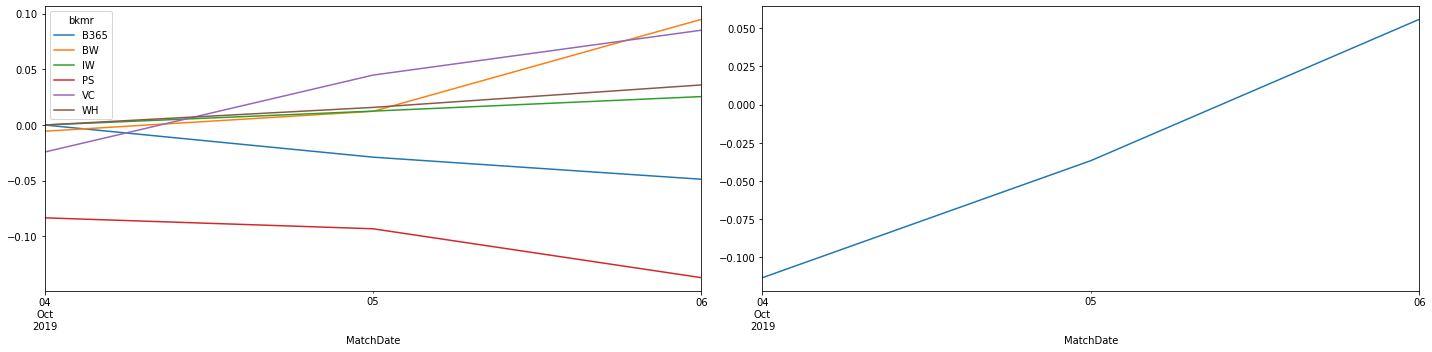

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
aux.margin.groupby(level=[0,3]).sum().unstack().cumsum().plot(ax=ax[0])
aux.margin.groupby(level=[0]).sum().cumsum().plot(ax=ax[1])
plt.tight_layout()

In [18]:
team_margin = pd.concat([aux.margin.groupby(level=1).sum(), 
                         aux.margin.groupby(level=2).sum()], 
                        axis=0).groupby(level=0).sum()

In [19]:
team_margin.sort_values(ascending=False).iloc[:150]

RB Leipzig       0.336890
Leverkusen       0.336890
Werder Bremen    0.255162
Ein Frankfurt    0.255162
Antwerp          0.144774
                   ...   
Wehen           -0.084600
Regensburg      -0.089600
Holstein Kiel   -0.089600
Man City        -0.215800
Wolves          -0.215800
Name: margin, Length: 70, dtype: float64

In [20]:
index = team_margin.sort_values(ascending=False).iloc[:150].index

In [21]:
team_margin.sort_values(ascending=False).iloc[:150].to_csv('./list_of_football_teams.csv')

/Users/Gabriele/Library/Mobile Documents/com~apple~CloudDocs/Kellify/Projects/ubipy/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [22]:
select = ((aux.index.get_level_values(1).isin(index)) | 
          (aux.index.get_level_values(2).isin(index)))

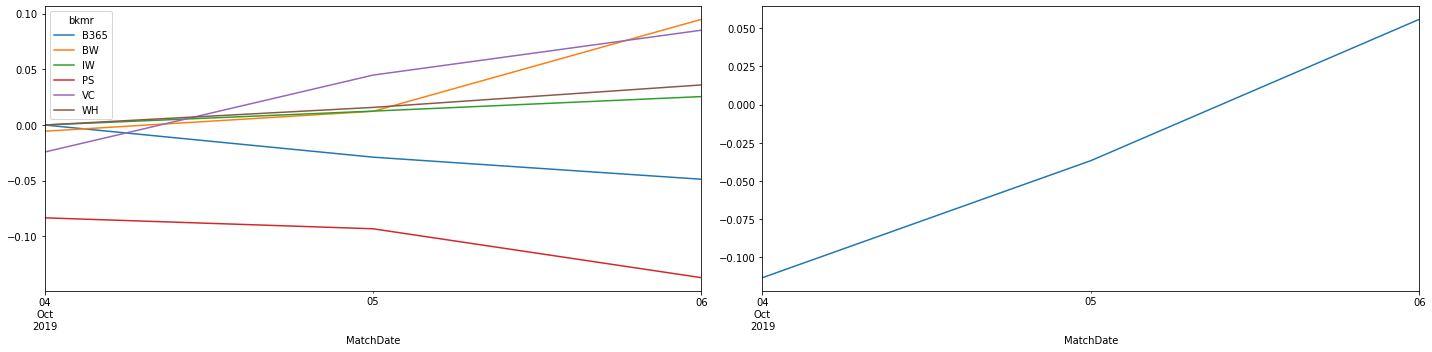

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
aux[select].margin.groupby(level=[0,3]).sum().unstack().cumsum().plot(ax=ax[0])
aux[select].margin.groupby(level=[0]).sum().cumsum().plot(ax=ax[1])
plt.tight_layout()

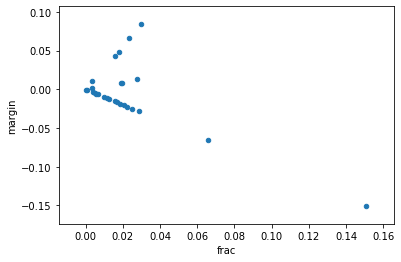

In [24]:
aux[select & (aux.margin != 0) & (aux.index.get_level_values(3) == 'PS')].plot.scatter(x='frac', y='margin')

In [25]:
aux.index.get_level_values(3).unique()

Index(['B365', 'BW', 'IW', 'PS', 'VC', 'WH'], dtype='object', name='bkmr')

In [28]:
aux[aux.frac > 0].to_csv('./football_sim_results.csv')